# **🏠EU's Residential Buildings Costs - Data Analytics Campaign**

## Data Preparation and Dataset Split

In [ ]:
import os
import pandas as pd
os.environ['OMP_NUM_THREADS'] = '1'

# Carica il dataset
dataset = pd.read_csv(r"dataset.csv")

# Splitta il dataset per Business Tendency Indicator (Cost)
df = dataset[dataset['indic_bt'] == 'COST']

# Prima rimuoviamo le righe dove unit è I15 o I21
df = df[~df['unit'].isin(['I15', 'I21'])]

mapping_aggregati = {
    'EA19': ['AT','BE','CY','EE','FI','FR','DE','GR','IE','IT','LV','LT','LU','MT','NL','PT','SK','SI','ES'],
    'EA20': ['AT','BE','CY','HR','EE','FI','FR','DE','GR','IE','IT','LV','LT','LU','MT','NL','PT','SK','SI','ES'],
    'EU27_2020': ['AT','BE','BG','HR','CY','CZ','DK','EE','FI','FR','DE','GR','HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO','SK','SI','ES','SE']
}

# 1) Separiamo le righe aggregate
aggregati_da_espandere = set(mapping_aggregati.keys())
df_agg = df[df['geo'].isin(aggregati_da_espandere)].copy()
df_rest = df[~df['geo'].isin(aggregati_da_espandere)].copy()

# 2) costruiamo il set di chiavi esistenti per paesi singoli
existing_keys = set(zip(df_rest['geo'], df_rest['TIME_PERIOD']))

# 2) Creiamo un DataFrame vuoto per le righe espanse
df_expanded = []

# 3) Per ogni riga in df_agg, generiamo copie per ciascun membro
for idx, row in df_agg.iterrows():
    codice_agg = row['geo']
    anno = row['TIME_PERIOD']
    paesi_membri = mapping_aggregati[codice_agg]

    for iso2 in paesi_membri:
         if (iso2, anno) in existing_keys:
            continue
         nuova_riga = row.copy()
         nuova_riga['geo'] = iso2
         nuova_riga['OBS_VALUE'] = round(nuova_riga['OBS_VALUE'], 1)
         df_expanded.append(nuova_riga)

# 4) Concateniamo df_rest e tutte le righe espanse in df_expanded
df_expanded = pd.DataFrame(df_expanded)
df_final = pd.concat([df_rest, df_expanded], ignore_index=True)

# df_final ora contiene tutte le righe non aggregate + copie per paesi singoli
df = df_final.copy()

# Rimuovere gli Outliers
df = df[~df['geo'].isin(['UA', 'TR', 'ME', 'RS', 'RO'])]

# Elimina le colonne vuote o rindondanti
df = df.drop(columns=['DATAFLOW', 'LAST UPDATE', 's_adj', 'indic_bt', 'freq', 'cpa2_1', 'CONF_STATUS', 'OBS_FLAG', 'unit'])
df = df.fillna(dataset.mean(numeric_only=True))

# Approssima OBS_VALUE a una cifra dopo la virgola
df['OBS_VALUE'] = df['OBS_VALUE'].round(1)

print(df.head(10))

In [ ]:
# Crea la tabella pivot
pivot_df = df.pivot_table(index='TIME_PERIOD', columns='geo', values='OBS_VALUE')

# Riapprossima perchè è coglione
pivot_df = pivot_df.round(1)

print(pivot_df)

## Data Imputation and Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Trasposizione
data = pivot_df.T

# 2. Rimuove righe completamente vuote
data = data.dropna(how='all')

# 3. Imputazione: riempi i NaN con la media di ogni riga
data_filled = data.apply(lambda column: column.fillna(column.mean().round(1)), axis=1)

# 4. Rimuovi righe che ancora hanno tutti NaN (es. Media era NaN)
data_filled = data_filled.dropna()

# 7. Standardizzazione
data_scaled = StandardScaler().fit_transform(data_filled)

print(data_filled.head(10))

## Feature Engineering

In [ ]:
# Prima, ordina per paese e anno
df = df.sort_values(by=['geo', 'TIME_PERIOD']).reset_index(drop=True)

# Creiamo un DataFrame con costi per paese e anno
# Raggruppiamo per 'geo' e poi applichiamo shift(-1) su OBS_VALUE per avere il valore dell’anno successivo
df['target_cost'] = df.groupby('geo')['OBS_VALUE'].shift(-1)

# Rimuovi righe dove target_cost è NaN (ultimo anno di ciascun paese)
df = df.dropna(subset=['target_cost'])

print(df[['geo', 'TIME_PERIOD', 'OBS_VALUE', 'target_cost']].head(10))

In [ ]:
# Calcola la variazione percentuale anno su anno
df['prev_cost'] = df.groupby('geo')['OBS_VALUE'].shift(1)
df['var_perc'] = (df['OBS_VALUE'] - df['prev_cost']) / df['prev_cost'] * 100.0

# Etichetta le classi
def label_func(x):
    if x > 15:
        return 'aumento'
    elif x < -15:
        return 'diminuzione'
    else:
        return 'stabile'

df['label_variation'] = df['var_perc'].apply(lambda x: label_func(x) if pd.notna(x) else None)

# Gestiamo i valori infiniti
df['var_perc'] = df['var_perc'].replace([np.inf, -np.inf], 100.0).round(1)

# Rimuovi righe dove prev_cost è NaN (primo anno di ciascun paese)
df = df.dropna(subset=['prev_cost', 'label_variation'])

print(df[['geo', 'TIME_PERIOD', 'OBS_VALUE', 'var_perc', 'label_variation']].head(10))

In [ ]:
# Media mobile su 3 anni (incluso l'anno corrente e i due precedenti)
df['rolling_mean_3'] = df.groupby('geo')['OBS_VALUE'].transform(lambda x: x.rolling(window=3, min_periods=1).mean()).round(1)

# Media mobile su 5 anni
df['rolling_mean_5'] = df.groupby('geo')['OBS_VALUE'].transform(lambda x: x.rolling(window=5, min_periods=1).mean()).round(1)

# Deviazione standard su 3 anni
df['rolling_std_3'] = df.groupby('geo')['OBS_VALUE'].transform(lambda x: x.rolling(window=3, min_periods=1).std()).round(1)

# Variazione percentuale media su 3 anni
df['pct_change_3'] = df.groupby('geo')['OBS_VALUE'].transform(lambda x: x.pct_change(periods=3)).round(1)

# 3) Sostituisci inf e -inf con NaN
df['pct_change_3'] = df['pct_change_3'].replace([np.inf, -np.inf], np.nan)

# Dato che il primo anno di ogni paese non ha tre valori precedenti, std e pct saranno NaN
# Sostituire NaN con 0 o con un valore minimo
df['rolling_std_3'] = df['rolling_std_3'].fillna(0.0)
df['pct_change_3'] = df['pct_change_3'].fillna(0.0)

# Feature binaria se var_perc > 0 (crescita dell’anno precedente)
df['grew_last_year'] = (df['var_perc'] > 0).astype(int)

# Slope di regressione lineare sui 3 anni precedenti (trend locale)
def local_slope(series):
    # Calcola slope ultimo valore basandosi sui 3 punti precedenti
    if series.shape[0] < 3:
        return 0
    y = series.values[-3:]
    x = np.arange(len(y))
    # fit lineare y = ax + b
    a, b = np.polyfit(x, y, 1)
    return a

df['slope_3'] = df.groupby('geo')['OBS_VALUE'].transform(lambda x: x.expanding().apply(local_slope, raw=False)).round(1)
print(df)

## Clustering: KMeans

In [ ]:
# 8. PCA a 3 componenti prima del clustering
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=42)
data_pca = pca.fit_transform(data_scaled)

# 9. Clustering con KMeans e silhouette score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_k = 2
best_score = -1
for k in range(2, min(11, data_pca.shape[0])):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_pca)
    score = silhouette_score(data_pca, labels)
    print(f"[PCA] Silhouette score per k={k}: {score:.3f}")
    if score > best_score:
        best_score = score
        best_k = k
print(f"\n[PCA] Miglior numero di cluster: {best_k} con Silhouette Score = {best_score:.3f}")

# 10. Applica KMeans finale
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(data_pca)

## Clustered Countries

In [ ]:
clustered_df = pd.DataFrame(data_filled)
clustered_df = clustered_df.rename(columns={'index': 'country'})
labels_df = pd.Series(labels)
clustered_df = clustered_df.iloc[:len(labels)]
clustered_df['cluster'] = labels
clustered_df.to_csv("clustered_countries.csv")
print(clustered_df.head())

## K-Means Visualization - Scatter Plot

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Riduci a 2 dimensioni per lo scatter plot
pca_2d = PCA(n_components=3, random_state=42)
data_2d = pca.fit_transform(data_scaled)

# Prima del plotting, verifichiamo le dimensioni
data_2d_len = len(data_2d)
labels_len = len(labels)

# Assicuriamoci che i dati siano della stessa lunghezza
data_2d = data_2d[:min(data_2d_len, labels_len)]
labels = labels[:min(data_2d_len, labels_len)]

# Ora creiamo il plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=labels, palette='tab10', s=80)

# Aggiungiamo le etichette solo per i punti che abbiamo effettivamente plottato
for i, name in enumerate(data_filled.index[:len(data_2d)]):
    plt.text(data_2d[i, 0]+0.2, data_2d[i, 1]+0.2, name, fontsize=8)
plt.title(f"Cluster con K={best_k}, Silhouette Score={best_score:.3f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

## K-Means Visualization - Geographic Map

In [ ]:
import plotly.express as px
import pycountry

def iso2_to_iso3(code):
    # Verifica se il codice è una stringa
    if not isinstance(code, str):
        return None
    # Normalizza il codice in maiuscolo
    code = code.upper()
    try:
        country = pycountry.countries.get(alpha_2=code)
        return country.alpha_3 if country else None
    except (AttributeError, LookupError):
        return None

iso3_codes = [iso2_to_iso3(c) for c in data_filled.index]

map_iso3 = [iso2_to_iso3(c) for c in data_filled.index]

map_k_df = pd.DataFrame({
    'iso_alpha': iso3_codes,
    'cluster': labels_df
}).dropna(subset=['iso_alpha'])

# 2) Disegniamo la choropleth per KMeans
fig_k = px.choropleth(
    map_k_df,
    locations='iso_alpha',
    color='cluster',
    hover_name='iso_alpha',
    color_discrete_sequence=px.colors.qualitative.Light24,
    projection="mercator",
    locationmode="ISO-3"
)
fig_k.update_geos(
    scope="europe",
    showcountries=True,
    showcoastlines=False,
    showland=True,
    fitbounds="locations"
)
fig_k.update_layout(
    title=f"KMeans (k={best_k}) – Cluster su mappa europea",
    margin={"r":0,"t":40,"l":0,"b":0}
)
fig_k.show()

## Re-Clustering: DBSCAN

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

nbrs = NearestNeighbors(n_neighbors=4).fit(data_scaled)  # k = min_samples
distances, indices = nbrs.kneighbors(data_scaled)

# Prendi la distanza k-esima per ogni punto e ordina
k_distances = np.sort(distances[:, 3])  # 3 perché 0=min_auto, 1,2,3=4th nearest neighbor
plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.ylabel('4th Nearest Neighbor Distance')
plt.xlabel('Sorted Points')
plt.title('k-distance Graph per DBSCAN')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# -------------------------------
# Grid-search per DBSCAN
# -------------------------------

# 1) Definire range di eps e min_samples da testare
eps_values = np.linspace(1.0, 8.0, num=15)
min_samples_values = list(range(3, 7))

best_score = -1
best_eps = None
best_min_samples = None

for eps_candidate in eps_values:
    for min_s in min_samples_values:
        db = DBSCAN(eps=eps_candidate, min_samples=min_s, metric='euclidean')
        labels_tmp = db.fit_predict(data_scaled)

        # Consideriamo solo i punti non outlier (label != -1)
        mask = labels_tmp != -1
        unique_clusters = set(labels_tmp[mask])

        # Serve almeno 2 cluster reali per silhouette; altrimenti skip
        if len(unique_clusters) <= 1:
            continue

        score_tmp = silhouette_score(data_scaled[mask], labels_tmp[mask])
        # Se il silhouette è migliorativo, aggiorniamo
        if score_tmp > best_score:
            best_score = score_tmp
            best_eps = eps_candidate
            best_min_samples = min_s

# 2) Stampa dei parametri ottimali (o avviso se non ne trovi)
if best_eps is None:
    print("DBSCAN grid-search: nessuna combinazione ha prodotto ≥2 cluster validi.")
    best_eps = 7.5
    best_min_samples = 5
    print(f"Usiamo valori di default eps={best_eps}, min_samples={best_min_samples}")
else:
    print(f"DBSCAN grid-search – miglior eps={best_eps:.2f}, min_samples={best_min_samples}, silhouette={best_score:.3f}")

# 3) Applichiamo DBSCAN finale con i parametri selezionati
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='euclidean')
labels_db = dbscan.fit_predict(data_scaled)

# Eventuale verifica finale della silhouette
mask_final = labels_db != -1
if len(set(labels_db[mask_final])) > 1:
    final_score = silhouette_score(data_scaled[mask_final], labels_db[mask_final])
    print(f"Silhouette finale (inlier): {final_score:.3f}")
else:
    print("DBSCAN finale: meno di 2 cluster validi o troppi outlier.")

## DBSCAN Visualization - Scatter Plot

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# PCA 2D per visualizzare tutti i punti (anche rumore)
pca2 = PCA(n_components=2, random_state=42)
data_pca2 = pca2.fit_transform(data_scaled)

plt.figure(figsize=(8, 6))
palette = sns.color_palette("tab10", len(set(labels_db)))
sns.scatterplot(x=data_pca2[:, 0], y=data_pca2[:, 1],
                hue=labels_db, palette=palette, legend="full", s=80)
n_points = min(len(data_filled.index), len(data_pca2))
countries = data_filled.index[:n_points]
for i, country in enumerate(countries):
    plt.text(data_pca2[i, 0] + 0.1, data_pca2[i, 1] + 0.1, country, fontsize=7)

plt.title(f"DBSCAN su PCA 2D")  #(Silhouette inlier: {score_db:.3f})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(title="Cluster DBSCAN", bbox_to_anchor=(1, 1))
plt.show()

## DBSCAN Visualization - Geographic Map

In [ ]:
import plotly.express as px

def iso2_to_iso3(code):
    try:
        country = pycountry.countries.get(alpha_2=code)
        return country.alpha_3 if country else None
    except AttributeError:
        return None

# Applichiamo la conversione
iso3_list = [iso2_to_iso3(c) for c in data_filled.index]

map_iso3 = [iso2_to_iso3(c) for c in data_filled.index]

# Prepara DataFrame per la mappa
map_df = pd.DataFrame({
    'iso_alpha': iso3_list,
    'cluster': labels_db
}).dropna(subset=['iso_alpha'])

fig = px.choropleth(
    map_df,
    locations='iso_alpha',
    color='cluster',
    hover_name='iso_alpha',
    color_discrete_sequence=px.colors.qualitative.Light24,
    projection="mercator",
    locationmode="ISO-3"
)

# Limita la mappa all’Europa
fig.update_geos(
    scope="europe",
    showcountries=True,
    showcoastlines=False,
    showland=True,
    fitbounds="locations"
)

fig.update_layout(
    title="Cluster DBSCAN su mappa europea",
    margin={"r": 0, "t": 40, "l": 0, "b": 0}
)

fig.show()

## Classification & Regression (Split Training-Testing)

In [ ]:
# Consideriamo solo le colonne numeriche candidate per la regressione
numerical_cols = ['OBS_VALUE', 'rolling_mean_3', 'rolling_std_3', 'grew_last_year', 'pct_change_3', 'rolling_mean_5', 'slope_3']

# Calcolo della matrice di correlazione
corr_matrix = df[numerical_cols].corr().abs()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title("Matrice di correlazione fra feature numeriche")
plt.show()

In [ ]:
# Feature Scelte per la regressione (coefficiente di correlazione < 0.8)
print(df[['geo', 'TIME_PERIOD', 'OBS_VALUE', 'pct_change_3', 'rolling_std_3', 'grew_last_year']].head(10))

In [ ]:
# Definiamo le feature candidate per regressione e classificazione
feature_cols = ['OBS_VALUE', 'pct_change_3', 'rolling_std_3', 'grew_last_year']

# Per regressione:
regression_df = df.dropna(subset=['target_cost']).copy()
X_reg = regression_df[feature_cols]
y_reg = regression_df['target_cost']

# Splitting: usiamo 'TIME_PERIOD' per train/test
train_mask = regression_df['TIME_PERIOD'] <= 2016
X_reg_train = X_reg[train_mask]
X_reg_test = X_reg[~train_mask]
y_reg_train = y_reg[train_mask]
y_reg_test = y_reg[~train_mask]

# Per classificazione:
classification_df = df.dropna(subset=['label_variation']).copy()
X_clf = classification_df[feature_cols]
y_clf = classification_df['label_variation']

# Stesso criterio temporale per la classificazione
train_mask_clf = classification_df['TIME_PERIOD'] <= 2016
X_clf_train = X_clf[train_mask_clf]
X_clf_test = X_clf[~train_mask_clf]
y_clf_train = y_clf[train_mask_clf]
y_clf_test = y_clf[~train_mask_clf]

print("Reg train size:", X_reg_train.shape, "Reg test size:", X_reg_test.shape)
print("Clf train size:", X_clf_train.shape, "Clf test size:", X_clf_test.shape)

## Decision Tree - Classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Prepara i dati (X_clf_train/Test e y_clf_train/Test già definiti)
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_clf_train, y_clf_train)

# Predizione
y_dt_clf_pred = dt_clf.predict(X_clf_test)

print("Decision Tree Classificazione – Report:\n", classification_report(y_clf_test, y_dt_clf_pred))

## Pruned Decision Tree - Classification

In [ ]:
# 1) Trova percorso di ccp_alpha ottimale
path_clf = dt_clf.cost_complexity_pruning_path(X_clf_train, y_clf_train)
ccp_alphas_clf = path_clf.ccp_alphas[:-1]
clf_trees = []
f1_scores = []

from sklearn.metrics import f1_score

for ccp in ccp_alphas_clf:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp)
    dt.fit(X_clf_train, y_clf_train)
    y_pred = dt.predict(X_clf_test)
    f1 = f1_score(y_clf_test, y_pred, average='weighted', zero_division=1)
    clf_trees.append(dt)
    f1_scores.append(f1)

best_index_clf = np.argmax(f1_scores)
best_alpha_clf = ccp_alphas_clf[best_index_clf]
best_dt_clf = clf_trees[best_index_clf]
print(f"Pruned Tree Classificazione – miglior ccp_alpha: {best_alpha_clf:.6f}, F1-weighted: {f1_scores[best_index_clf]:.3f}")

# Confronto con DT non potato
base_f1 = f1_score(y_clf_test, y_dt_clf_pred, average='weighted', zero_division=1)
print(f"DT non potato F1-weighted: {base_f1:.3f}")

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title='Matrice di Confusione'):
    # Calcola la matrice di confusione
    cm = confusion_matrix(y_true, y_pred)

    # Ottieni le classi uniche
    classes = sorted(set(y_true))

    # Crea la figura
    plt.figure(figsize=(5, 4))

    # Crea heatmap con seaborn
    sns.heatmap(cm,
                annot=True,  # Mostra i valori nelle celle
                fmt='d',     # Formato numeri interi
                cmap='Blues',  # Palette di colori
                xticklabels=classes,
                yticklabels=classes)

    # Personalizza il grafico
    plt.title(title, pad=20)
    plt.xlabel('Predetto')
    plt.ylabel('Reale')

    # Aggiungi percentuali di accuratezza per ogni classe
    accuracies = cm.diagonal() / cm.sum(axis=1)
    for i, accuracy in enumerate(accuracies):
        plt.text(-0.5, i, f'{accuracy:.1%}',
                va='center',
                ha='right',
                fontsize=10)

    plt.tight_layout()
    plt.show()

# Visualizza la matrice per il Decision Tree originale
plot_confusion_matrix(y_clf_test, y_dt_clf_pred,
                     title='Matrice di Confusione - Decision Tree')

# Visualizza la matrice per il Decision Tree potato
plot_confusion_matrix(y_clf_test, best_dt_clf.predict(X_clf_test),
                     title='Matrice di Confusione - Decision Tree Potato')

## Decision Tree - Regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepara i dati (assumendo tu abbia X_reg_train/Test e y_reg_train/Test già definiti)
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_reg_train, y_reg_train)

# Predizioni
y_dt_pred = dt_reg.predict(X_reg_test)

# Metriche iniziali
rmse_dt = mean_squared_error(y_reg_test, y_dt_pred)
mae_dt  = mean_absolute_error(y_reg_test, y_dt_pred)
r2_dt   = r2_score(y_reg_test, y_dt_pred)

print(f"Decision Tree Regressione – RMSE: {rmse_dt:.3f}, MAE: {mae_dt:.3f}, R²: {r2_dt:.3f}")

## Pruned Decision Tree - Regression

In [ ]:
# 1) Trova il percorso di ccp_alpha ottimale
from sklearn.tree import DecisionTreeRegressor

path = dt_reg.cost_complexity_pruning_path(X_reg_train, y_reg_train)
ccp_alphas = path.ccp_alphas[:-1]  # l’ultimo crea un albero con un solo nodo
reg_trees = []
rmse_scores = []

ccp_alphas = np.maximum(ccp_alphas, 0.0)

for ccp in ccp_alphas:
    dt = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp)
    dt.fit(X_reg_train, y_reg_train)
    y_pred = dt.predict(X_reg_test)
    rmse_val = mean_squared_error(y_reg_test, y_pred)
    reg_trees.append(dt)
    rmse_scores.append(rmse_val)

# Seleziona l’alpha che minimizza RMSE
best_index = np.argmin(rmse_scores)
best_alpha = ccp_alphas[best_index]
best_dt = reg_trees[best_index]
print(f"Pruned Tree – miglior ccp_alpha: {best_alpha:.6f}, RMSE: {rmse_scores[best_index]:.3f}")

# Confronto con il DT non potato
print(f"DT non potato RMSE: {rmse_dt:.3f}")

## Diagnostica di Regressione

In [ ]:
def plot_regression_diagnostics(y_true, y_pred, title='Diagnostica Regressione'):
    # Calcola i residui
    residuals = y_true - y_pred

    # Crea una figura con 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle(title, fontsize=16, y=1.02)

    # 1. Valori Predetti vs Valori Reali
    axes[0,0].scatter(y_true, y_pred, alpha=0.5)
    axes[0,0].plot([y_true.min(), y_true.max()],
                   [y_true.min(), y_true.max()],
                   'r--', lw=2)
    axes[0,0].set_xlabel('Valori Reali')
    axes[0,0].set_ylabel('Valori Predetti')
    axes[0,0].set_title('Predetti vs Reali')

    # 2. Distribuzione dei Residui
    sns.histplot(residuals, kde=True, ax=axes[0,1])
    axes[0,1].axvline(x=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Residui')
    axes[0,1].set_title('Distribuzione dei Residui')

    # 3. Residui vs Valori Predetti
    axes[1,0].scatter(y_pred, residuals, alpha=0.5)
    axes[1,0].axhline(y=0, color='r', linestyle='--')
    axes[1,0].set_xlabel('Valori Predetti')
    axes[1,0].set_ylabel('Residui')
    axes[1,0].set_title('Residui vs Predetti')

    # 4. Q-Q Plot dei Residui
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot dei Residui')

    # Aggiungi metriche di performance
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics_text = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.2f}'
    fig.text(0.02, 0.98, metrics_text, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Visualizza diagnostica per il Decision Tree originale
plot_regression_diagnostics(y_reg_test,
                          dt_reg.predict(X_reg_test),
                          'Diagnostica Regressione - Decision Tree')

# Visualizza diagnostica per il Decision Tree potato
plot_regression_diagnostics(y_reg_test,
                          best_dt.predict(X_reg_test),
                          'Diagnostica Regressione - Decision Tree Potato')

## Decision Trees - Visualization

In [ ]:
# Per la visualizzazione dei Decision Tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 1. Decision Tree Classificazione
plt.figure(figsize=(20,10))
plot_tree(dt_clf,
          feature_names=feature_cols,
          class_names=sorted(y_clf_train.unique()),
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree - Classificazione (Non Potato)")
plt.show()

# 2. Decision Tree Classificazione Potato
plt.figure(figsize=(20,10))
plot_tree(best_dt_clf,
          feature_names=feature_cols,
          class_names=sorted(y_clf_train.unique()),
          filled=True,
          rounded=True,
          fontsize=10)
plt.title(f"Decision Tree - Classificazione (Potato con ccp_alpha={best_alpha_clf:.6f})")
plt.show()

# 3. Decision Tree Regressione
plt.figure(figsize=(20,10))
plot_tree(dt_reg,
          feature_names=feature_cols,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree - Regressione (Non Potato)")
plt.show()

# 4. Decision Tree Regressione Potato
plt.figure(figsize=(20,10))
plot_tree(best_dt,
          feature_names=feature_cols,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title(f"Decision Tree - Regressione (Potato con ccp_alpha={best_alpha:.6f})")
plt.show()

# 5. Grafico dell'andamento dell'errore in funzione di ccp_alpha
plt.figure(figsize=(10,6))
plt.plot(ccp_alphas_clf, f1_scores, marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('F1-score')
plt.title('F1-score vs ccp_alpha (Classificazione)')
plt.grid(True)
plt.show()

# 6. Grafico dell'andamento dell'errore in funzione di ccp_alpha per regressione
plt.figure(figsize=(10,6))
plt.plot(ccp_alphas, rmse_scores, marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs ccp_alpha (Regressione)')
plt.grid(True)
plt.show()

## Random Forest - Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Crea e addestra il modello
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_reg_train, y_reg_train)

# 1. Fai le predizioni
y_reg_pred = regressor.predict(X_reg_test)

# 2. Calcola le metriche
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
mae = mean_absolute_error(y_reg_test, y_reg_pred)
r2 = r2_score(y_reg_test, y_reg_pred)

print(f"Regressione – RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

## SMOTE & Random Forest - Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter

# 0. Verifica della distribuzione delle classi
print("Distribuzione delle classi nel training set:")
print(y_clf_train.value_counts(normalize=True) * 100)
print("\nDistribuzione delle classi nel test set:")
print(y_clf_test.value_counts(normalize=True) * 100)

# 1. Crea e addestra il modello
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_clf_train, y_clf_train)

# 2. Predici sui dati di test
y_clf_pred = clf.predict(X_clf_test)

# 3. Calcola le metriche
print("Classification Report:\n", classification_report(y_clf_test, y_clf_pred, zero_division=1))

# Applica SMOTE solo al training set
smote = SMOTE(random_state=42)
X_clf_train_balanced, y_clf_train_balanced = smote.fit_resample(X_clf_train, y_clf_train)

print("\nDistribuzione originale delle classi:", Counter(y_clf_train))
print("Distribuzione dopo SMOTE:", Counter(y_clf_train_balanced))

# Addestra il modello con i dati bilanciati
clf_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
clf_balanced.fit(X_clf_train_balanced, y_clf_train_balanced)

# Fai predizioni e valuta
y_clf_pred_balanced = clf_balanced.predict(X_clf_test)
print("\nReport di classificazione con SMOTE:")
print(classification_report(y_clf_test, y_clf_pred_balanced, zero_division=1))

def plot_confusion_matrix_detailed(y_true, y_pred, title='Matrice di Confusione Dettagliata'):
    # Calcola la matrice di confusione
    cm = confusion_matrix(y_true, y_pred)

    # Calcola le percentuali per ogni riga
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Ottieni le classi uniche
    classes = sorted(set(y_true))

    # Crea la figura
    plt.figure(figsize=(5, 4))

    # Crea la heatmap principale
    sns.heatmap(cm, annot=np.asarray([
        [f'{count}\n({percentage:.1f}%)'
         for count, percentage in zip(row_counts, row_percentages)]
        for row_counts, row_percentages in zip(cm, cm_percentage)
    ]),
                fmt='',
                cmap='Blues',
                xticklabels=classes,
                yticklabels=classes,
                cbar_kws={'label': 'Numero di campioni'})

    # Aggiungi le etichette e il titolo
    plt.title(title, pad=20, fontsize=14)
    plt.xlabel('Classe Predetta', fontsize=12)
    plt.ylabel('Classe Reale', fontsize=12)

    plt.tight_layout()
    plt.show()

# Valutiamo i modelli
plot_confusion_matrix_detailed(y_clf_test, y_clf_pred, "Modello Base")
plot_confusion_matrix_detailed(y_clf_test, y_clf_pred_balanced, "Modello con SMOTE")

## Feature Importance

In [ ]:
# Visualizziamo le feature importance
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 6))
    plt.title(f"Feature Importance ({title})")
    plt.bar(range(X_clf_train.shape[1]), importances[indices])
    plt.xticks(range(X_clf_train.shape[1]), [feature_names[i] for i in indices], rotation=0)
    plt.tight_layout()
    plt.show()

# Visualizza feature importance per ogni modello
plot_feature_importance(clf, feature_cols, "Modello Base")
plot_feature_importance(clf_balanced, feature_cols, "Modello con SMOTE")

## Predicted Models Export (.csv)

In [ ]:
# 1) Esporta dataset pulito con feature e target per regressione e classificazione
df.to_csv("dataset_for_models.csv", index=False)

# 2) Esporta previsioni del modello di regressione (aggiungiamo una colonna con y_reg_pred)
regression_df = regression_df.copy()
regression_df['pred_cost'] = regressor.predict(regression_df[feature_cols]).round(1)
regression_df[['geo', 'TIME_PERIOD', 'OBS_VALUE', 'pred_cost']].to_csv("regression_results.csv", index=False)

# 3) Esporta etichette di variazione (classification) con probabilità
probs = clf.predict_proba(X_clf_test).round(1)
classification_output = classification_df.loc[~train_mask_clf, ['geo', 'TIME_PERIOD', 'OBS_VALUE', 'label_variation']].copy()
# Assumiamo che le classi siano ['aumento','diminuzione','stabile'] nell’ordine di clf.classes_
for idx, cls in enumerate(clf.classes_):
    classification_output[f"prob_{cls}"] = probs[:, idx]
classification_output.to_csv("classification_results.csv", index=False)

print("Dataset pulito con feature e target per regressione e classificazione:")
print(regression_df)

In [ ]:
print("Dataset con etichette di variazione (classification):")
print(classification_df)

## Proof of Concepts

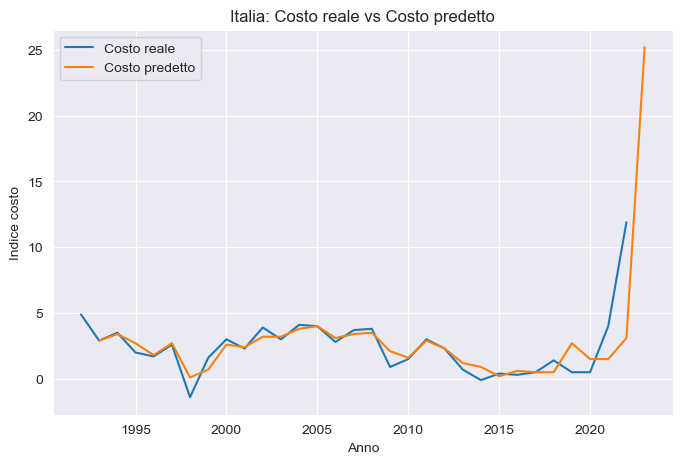

In [620]:
import matplotlib.pyplot as plt
import seaborn as sns

# Esempio: confronto tra COST reale e COST predetto per un dato paese (es. 'IT')
it_df = regression_df[regression_df['geo'] == 'IT'].copy()
it_df['year_pred'] = it_df['TIME_PERIOD'] + 1

plt.figure(figsize=(8,5))
# Costo reale in t
sns.lineplot(x='TIME_PERIOD', y='OBS_VALUE', data=it_df, label='Costo reale')
# Costo predetto allineato su year_pred (cioè pred_cost in anno t)
sns.lineplot(x='year_pred', y='pred_cost', data=it_df, label='Costo predetto')
plt.title("Italia: Costo reale vs Costo predetto")
plt.xlabel("Anno")
plt.ylabel("Indice costo")
plt.legend()
plt.grid(True)
plt.show()